In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from IPython.display import HTML
import matplotlib as mpl
#enable latex editing
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
mpl.rc('font', **font)
import matplotlib.pylab as pylab
params = {'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
#might need this to get the movie output working
%matplotlib notebook 

In [3]:
from ipynb.fs.full.NPV_and_LCOE import NPV,NPV2,LCOE  #need: pip install ipynb

In [6]:
filename="./Energy_src_parameters_2019.xlsx"  #Has collection of different parameters from different sources
#some artistic license has been used in adding missing entries

In [7]:
xl = pd.ExcelFile(filename)

In [ ]:
names=xl.sheet_names 

In [6]:
print(names)

['Parameters ATB', 'Parameters Fraunhofer 2018', 'Parameters LUT', 'Parameters Narrow', 'Danish data', 'Danish Coal refurbish', 'LUT coal extend', 'EIA', 'EIA existing', 'References']


In [7]:
for i in range(len(names)-1):
    df = pd.read_excel(filename,sheet_name=names[i]) 

In [8]:
#df = pd.read_excel(filename,sheet_name=names[0]) #ATB
df = pd.read_excel(filename,sheet_name=names[2]) #LUT
#df = pd.read_excel(filename,sheet_name=names[1]) #Fraunhofer...somewhat
#df = pd.read_excel(filename,sheet_name=names[3]) #Playground with small uncertainty

In [9]:
keynames=df.keys()
dimensions=df.shape
keynames

Index(['Roughly LUT parameters', 'Units', 'Wind onshore', 'Wind offshore',
       'PV', 'PV rooftop', 'Nuclear', 'Natural gas CCGT', 'Natural gas OCGT',
       'Coal', 'Coal extend'],
      dtype='object')

In [11]:
#How many techs have been implemented? 1st two columns are parameter names and units
ntech=dimensions[1]-2
#How many parameters each have 
nparams=dimensions[0]

In [12]:
techdata=np.zeros([nparams,ntech])

In [13]:
#Parameter names
param_names=df[keynames[0]]
print(param_names)

0                        CAPEX min
1                    CAPEX typical
2                        CAPEX max
3                         lifetime
4            Construction time min
5        Construction time typical
6            Construction time max
7                Discount rate min
8                Discount rate max
9              Capacity factor min
10         Capacity factor typical
11             Capacity factor max
12                       FIXED O&M
13                    Variable O&M
14                       Heat rate
15    Fuel cost min primary energy
16    Fuel cost max primary energy
17           Exchange euro to euro
18               Fuel cost min MWh
19               Fuel cost max MWh
20                   CO2 intensity
Name: Roughly LUT parameters, dtype: object


In [14]:
for i in range(ntech):
    #test=pd.DataFrame(df,columns=[keynames[i+2]])
    test=df[keynames[i+2]]
    techdata[:,i]=test[0:]

In [15]:
i=0
x=0
co=0
dsamples=4
discounts=np.zeros(dsamples)
discounts[0]=0.01
discounts[1]=0.05
discounts[2]=0.1
discounts[3]=-0.05
co2min=0
co2max=0.0  #euros/ton CO2
CO2samples=dsamples
CO2v=np.linspace(co2min,co2max,CO2samples)
samples=100000
NPV_techv=np.zeros([samples,CO2samples,ntech])
LCOE_techv=np.zeros([samples,CO2samples,ntech])
It0v=np.zeros([samples,CO2samples,ntech])
rv=np.zeros([samples,CO2samples,ntech])
cfv=np.zeros([samples,CO2samples,ntech])
wholesalemin=40   #20
wholesalemax=60   #80
It0=np.random.uniform(low=techdata[0,i],high=techdata[2,i])
n=int(techdata[3,i])
construction_period=int(np.random.uniform(low=techdata[4,i],high=techdata[6,i]))
cf=np.random.uniform(low=techdata[9,i],high=techdata[11,i])
r=np.random.uniform(low=techdata[7,i],high=techdata[8,i])
OMkwh=(techdata[13,i]+np.random.uniform(low=techdata[18,i],high=techdata[19,i]))/1000  #Euros/kWh variable O&M
OMfixed=techdata[12,i]
CO2intensity=techdata[20,i]  #tons CO2/MWh
NPV_techv[x,co,i]=NPV2(construction_period,n,r,cf,It0,OMkwh+CO2intensity*CO2v[0]/1000,OMfixed,wholesalemin,wholesalemax)/It0
print(NPV_techv[x,co,i])

-0.2107784217894939


In [15]:
#Loop over all techs and generate all samples
#for i in range(ntech):
for i in range(1):    
    print('Techonology: ',keynames[i+2],i)
    n=int(techdata[3,i])
    OMfixed=techdata[12,i]
    CO2intensity=techdata[20,i]
    for co in range(dsamples):
        r=discounts[co]
        for x in range(samples):
            It0=np.random.uniform(low=techdata[0,i],high=techdata[2,i])            
            construction_period=int(np.random.uniform(low=techdata[4,i],high=techdata[6,i]))
            cf=np.random.uniform(low=techdata[9,i],high=techdata[11,i])   
            rv[x,co,i]=r
            It0v[x,co,i]=It0
            cfv[x,co,i]=cf
            OMkwh=(techdata[13,i]+np.random.uniform(low=techdata[18,i],high=techdata[19,i]))/1000  #Euros/kWh variable O&M
            NPV_techv[x,co,i]=NPV2(construction_period,n,r,cf,It0,OMkwh+CO2intensity*CO2v[co]/1000,OMfixed,wholesalemin,wholesalemax)/It0
            LCOE_techv[x,co,i]=LCOE(construction_period,n,r,cf,It0,OMkwh+CO2intensity*CO2v[co]/1000,OMfixed)*1000 #euros/MWh

Techonology:  Wind onshore 0


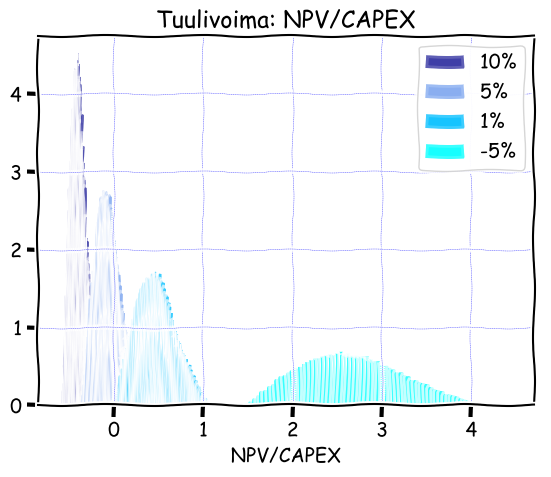

In [18]:
rc('text', usetex=False)
mpl.rcParams.update(mpl.rcParamsDefault)
with plt.xkcd():
    
    plt.hist([NPV_techv[:,2,0]], bins=75,alpha=0.5,density=True,color = ["darkblue"],label='10%')
    plt.hist([NPV_techv[:,1,0]], bins=75,alpha=0.5,density=True,color = ["cornflowerblue"],label='5%')
    plt.hist([NPV_techv[:,0,0]], bins=75,alpha=0.7,density=True,color = ["deepskyblue"],label='1%')
    plt.hist([NPV_techv[:,3,0]], bins=75,alpha=0.7,density=True,color = ["aqua"],label='-5%')
    plt.legend(loc='upper right')
    plt.title("Tuulivoima: NPV/CAPEX")
    plt.xlabel("NPV/CAPEX")
    plt.grid(color='b', linestyle='--', linewidth=0.25)
    plt.savefig('./Wind_discounts_XKCD_negative_also.png',bbox_inches='tight')
    plt.show()

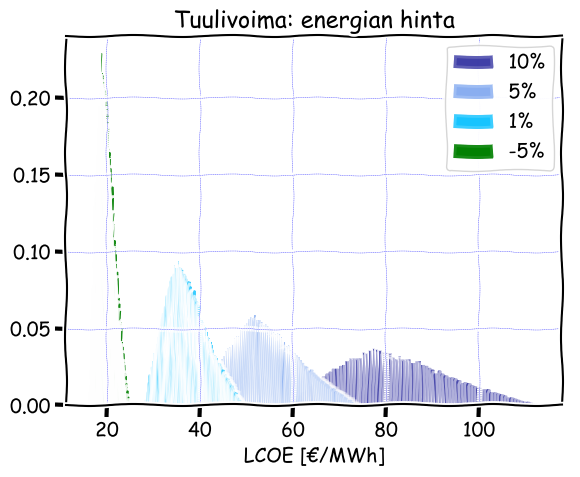

In [21]:
rc('text', usetex=False)
mpl.rcParams.update(mpl.rcParamsDefault)
with plt.xkcd():
    plt.hist([LCOE_techv[:,2,0]], bins=75,alpha=0.5,density=True,color = ["darkblue"],label='10%')
    plt.hist([LCOE_techv[:,1,0]], bins=75,alpha=0.5,density=True,color = ["cornflowerblue"],label='5%')
    plt.hist([LCOE_techv[:,0,0]], bins=75,alpha=0.7,density=True,color = ["deepskyblue"],label='1%')
    plt.hist([LCOE_techv[:,3,0]], bins=75,alpha=0.9,density=True,color = ["green"],label='-5%')
    plt.legend(loc='upper right')
    plt.title("Tuulivoima: energian hinta")
    plt.xlabel("LCOE [€/MWh]")
    plt.grid(color='b', linestyle='--', linewidth=0.25)
    plt.savefig('./Wind_discounts_LCOE_XKCD_also_negative.png',bbox_inches='tight')
    plt.show()

<Figure size 640x480 with 0 Axes>

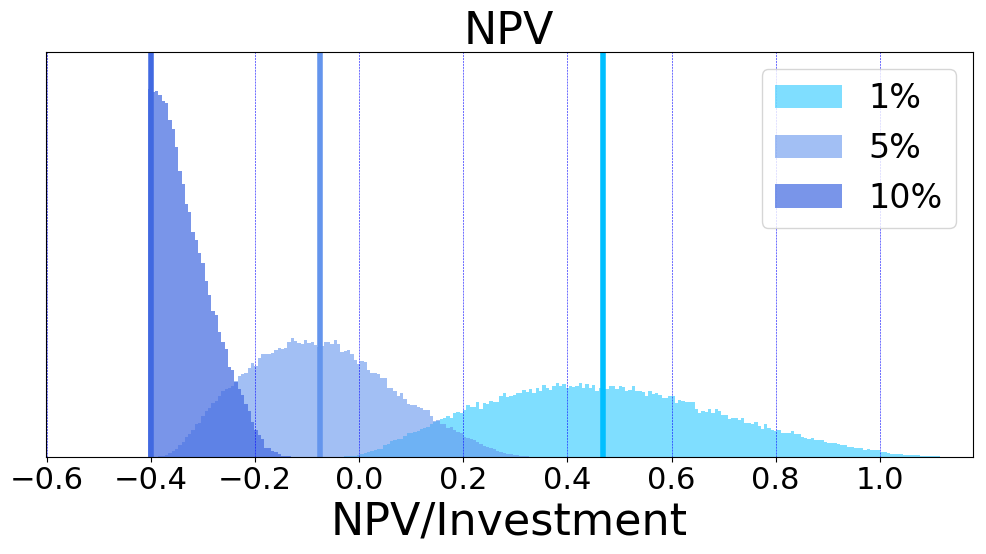

In [30]:
plt.clf()
mpl.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(10,6))
#plt.style.use('dark_background')
#ax = fig.add_subplot(111)
#ax.tick_params(axis='both', which='major', labelsize=32)
plt.clf()
#plt.xticks(fontsize=32)
minval1=NPV_techv[:,0,0].min()
maxval1=NPV_techv[:,0,0].max()
minval2=NPV_techv[:,1,0].min()
maxval2=NPV_techv[:,1,0].max()
minval3=NPV_techv[:,1,0].min()
maxval3=NPV_techv[:,1,0].max()
minval=min(minval1,minval2,minval3)
maxval=max(maxval1,maxval2,maxval3)
bins_fixed = np.linspace(minval,maxval, 250)
#mpl.rcParams['text.usetex'] = False
#with plt.xkcd():
colorv=['deepskyblue','cornflowerblue','royalblue']
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
CO2taxv=np.zeros(1)
ti=0
ti2=0
ti3=0
colorh=colorv[0]
colorh2=colorv[1]
colorh3=colorv[2]
yn, xp, _ =plt.hist(NPV_techv[:,0,0], bins_fixed,alpha=0.5,density=True,label='1%',color=colorh)
yn2, xp, _ =plt.hist(NPV_techv[:,1,0], bins_fixed,alpha=0.6,density=True,label='5%',color=colorh2)
yn3, xp, _ =plt.hist(NPV_techv[:,2,0], bins_fixed,alpha=0.7,density=True,label='10%',color=colorh3)
ymax1=yn.max()
ymax2=yn2.max()
ymax3=yn3.max()
ymax=max(ymax1,ymax2,ymax3)
xv=np.ones(2)*np.mean(NPV_techv[:,0,ti])
yv=np.zeros(2)
yv[1]=ymax*1.1
plt.plot(xv,yv,color=colorh, linewidth=4)
xv2=np.ones(2)*np.mean(NPV_techv[:,1,ti2])
xv3=np.ones(2)*np.mean(NPV_techv[:,2,ti3])
plt.plot(xv2,yv,color=colorh2, linewidth=4)
plt.plot(xv3,yv,color=colorh3, linewidth=4)
plt.legend(loc='upper right', prop={'size': 24})
plt.title("NPV",fontsize=32)
#plt.title("LCOE: CO$_{2}$="+str(round(CO2taxv[i],1))+" €/MWh", fontsize=32)
plt.xlabel("NPV/Investment", fontsize=32)
xmin1=np.min(NPV_techv[:,0,0])
xmin2=np.min(NPV_techv[:,1,0])
xmin3=np.min(NPV_techv[:,2,0])
xmax1=np.max(NPV_techv[:,0,0])
xmax2=np.max(NPV_techv[:,1,0])
xmax3=np.max(NPV_techv[:,2,0])
xmax=max(xmax1,xmax2,xmax3)
xmin=min(xmin1,xmin2,xmin3)
plt.xlim(xmin,xmax)
plt.ylim((0,yv[1]))
plt.yticks([])
plt.grid(color='b', linestyle='--', linewidth=0.4)
plt.tight_layout()
filenamepng= "./Wind_discounts2.png"
#filenamepdf= "./Figs/sample" + str(co)+ ".pdf"    
plt.savefig(filenamepng,dpi=300)
#plt.savefig(filenamepdf)
im=plt.show()

In [16]:
#All technologies samples
for i in range(ntech):    
#for i in range(1):    
    print('Techonology: ',keynames[i+2],i)
    n=int(techdata[3,i])
    OMfixed=techdata[12,i]
    CO2intensity=techdata[20,i]
    for co in range(dsamples):
        r=discounts[co]
        for x in range(samples):
            It0=np.random.uniform(low=techdata[0,i],high=techdata[2,i])            
            construction_period=int(np.random.uniform(low=techdata[4,i],high=techdata[6,i]))
            cf=np.random.uniform(low=techdata[9,i],high=techdata[11,i])   
            rv[x,co,i]=r
            It0v[x,co,i]=It0
            cfv[x,co,i]=cf
            OMkwh=(techdata[13,i]+np.random.uniform(low=techdata[18,i],high=techdata[19,i]))/1000  #Euros/kWh variable O&M
            NPV_techv[x,co,i]=NPV2(construction_period,n,r,cf,It0,OMkwh+CO2intensity*CO2v[co]/1000,OMfixed,wholesalemin,wholesalemax)/It0
            LCOE_techv[x,co,i]=LCOE(construction_period,n,r,cf,It0,OMkwh+CO2intensity*CO2v[co]/1000,OMfixed)*1000 #euros/MWh

Techonology:  Wind onshore 0
Techonology:  Wind offshore 1
Techonology:  PV 2
Techonology:  PV rooftop 3
Techonology:  Nuclear 4
Techonology:  Natural gas CCGT 5
Techonology:  Natural gas OCGT 6
Techonology:  Coal 7
Techonology:  Coal extend 8


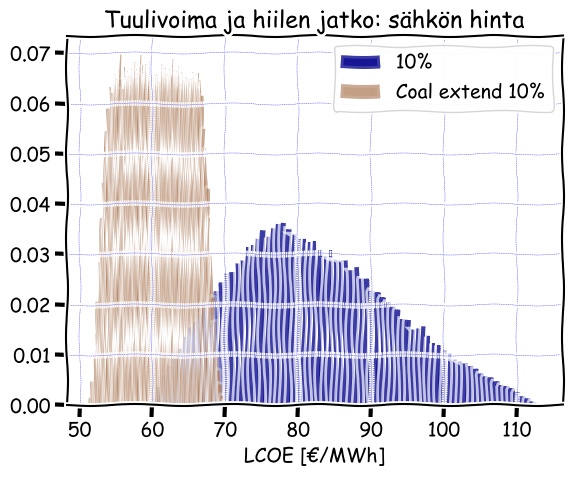

In [53]:
#Compare wind and coal
rc('text', usetex=False)
mpl.rcParams.update(mpl.rcParamsDefault)
with plt.xkcd():
    ti=0
    ti2=8   #or 8 for erxtend coal
    di=2   #0=1% 2=10%
    #plt.hist([LCOE_techv[:,2,ti]], bins=75,alpha=0.5,density=True,color = ["darkblue"],label='10%')
    plt.hist([LCOE_techv[:,di,ti]], bins=75,alpha=0.7,density=True,color = ["darkblue"],label='10%')
    #plt.hist([LCOE_techv[:,2,ti2]], bins=75,alpha=0.3,density=True,color = ["saddlebrown"],label='Coal extend 10%')
    plt.hist([LCOE_techv[:,di,ti2]], bins=75,alpha=0.3,density=True,color = ["saddlebrown"],label='Coal extend 10%')
    plt.legend(loc='upper right')
    plt.title("Tuulivoima ja hiilen jatko: sähkön hinta")
    plt.xlabel("LCOE [€/MWh]")
    plt.grid(color='b', linestyle='--', linewidth=0.25)
    plt.savefig('./Wind_Coalextend_discount10_LCOE_XKCD.png',bbox_inches='tight')
    plt.show()

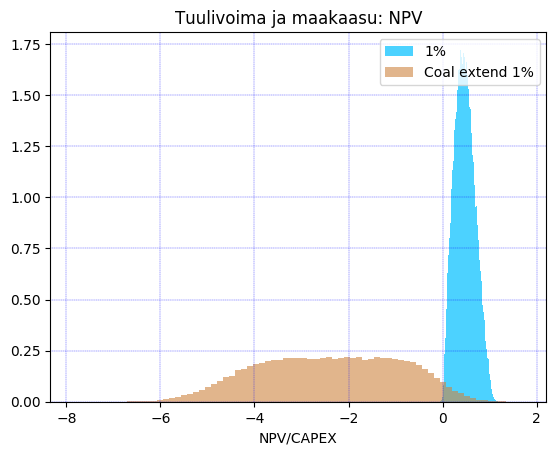

In [48]:
#Compare wind and coal
rc('text', usetex=False)
mpl.rcParams.update(mpl.rcParamsDefault)
#with plt.xkcd():
for ind in range(1):
    ti=0
    ti2=8   #or 8 for extend coal
    di=0   #0=1% 2=10%
    if di==0:
        plt.hist([NPV_techv[:,di,ti]], bins=75,alpha=0.7,density=True,color = ["deepskyblue"],label='1%')
        plt.hist([NPV_techv[:,di,ti2]], bins=75,alpha=0.6,density=True,color = ["peru"],label='Coal extend 1%')
        filenameh='./Wind_Coalextend_discount1_NPV.png'        
    else:
        plt.hist([NPV_techv[:,di,ti]], bins=75,alpha=0.7,density=True,color = ["deepskyblue"],label='10%')
        plt.hist([NPV_techv[:,di,ti2]], bins=75,alpha=0.6,density=True,color = ["peru"],label='Coal extend 10%')
        filenameh='./Wind_Coalextend_discount10_NPV.png'        
    plt.legend(loc='upper right')
    plt.title("Tuulivoima ja maakaasu: NPV")
    plt.xlabel("NPV/CAPEX")
    plt.grid(color='b', linestyle='--', linewidth=0.25)
    plt.savefig(filenameh,bbox_inches='tight')
    plt.show()